In [1]:
import os
import faiss
import torch
import torchvision.transforms as T
import numpy as np
from PIL import Image
from transformers import AutoFeatureExtractor, AutoModel

c:\Users\sunny\Desktop\Home\Projects\Python\Visual Search\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from similarity import find_similar_images

In [4]:
indexes, distances = find_similar_images(embeddings[10], k = 5)

Attempting to load index from index
Index loaded from index
Index type: <class 'faiss.swigfaiss_avx2.IndexFlatL2'>


: 

In [9]:
embeddings[10].shape

(768,)

In [3]:
embeddings = np.load("embeddings.npy")
ids = np.load("ids.npy")
embeddings[0].shape

(768,)

In [3]:
def build_faiss_index(embeddings, d = 768):
    index = faiss.IndexFlatL2(d)  # L2 distance
    index.add(embeddings)
    return index

faiss_index = build_faiss_index(embeddings)

In [4]:
def find_similar_images(index, query_embedding, k=5):
    distances, indices = index.search(query_embedding.reshape(1, -1), k)
    return distances[0], indices[0]

In [19]:
query_embedding = embeddings[6837]
distances, indices = find_similar_images(faiss_index, query_embedding, k=5)

print("Indices of similar images:", indices)
print("Distances to similar images:", distances)

: 

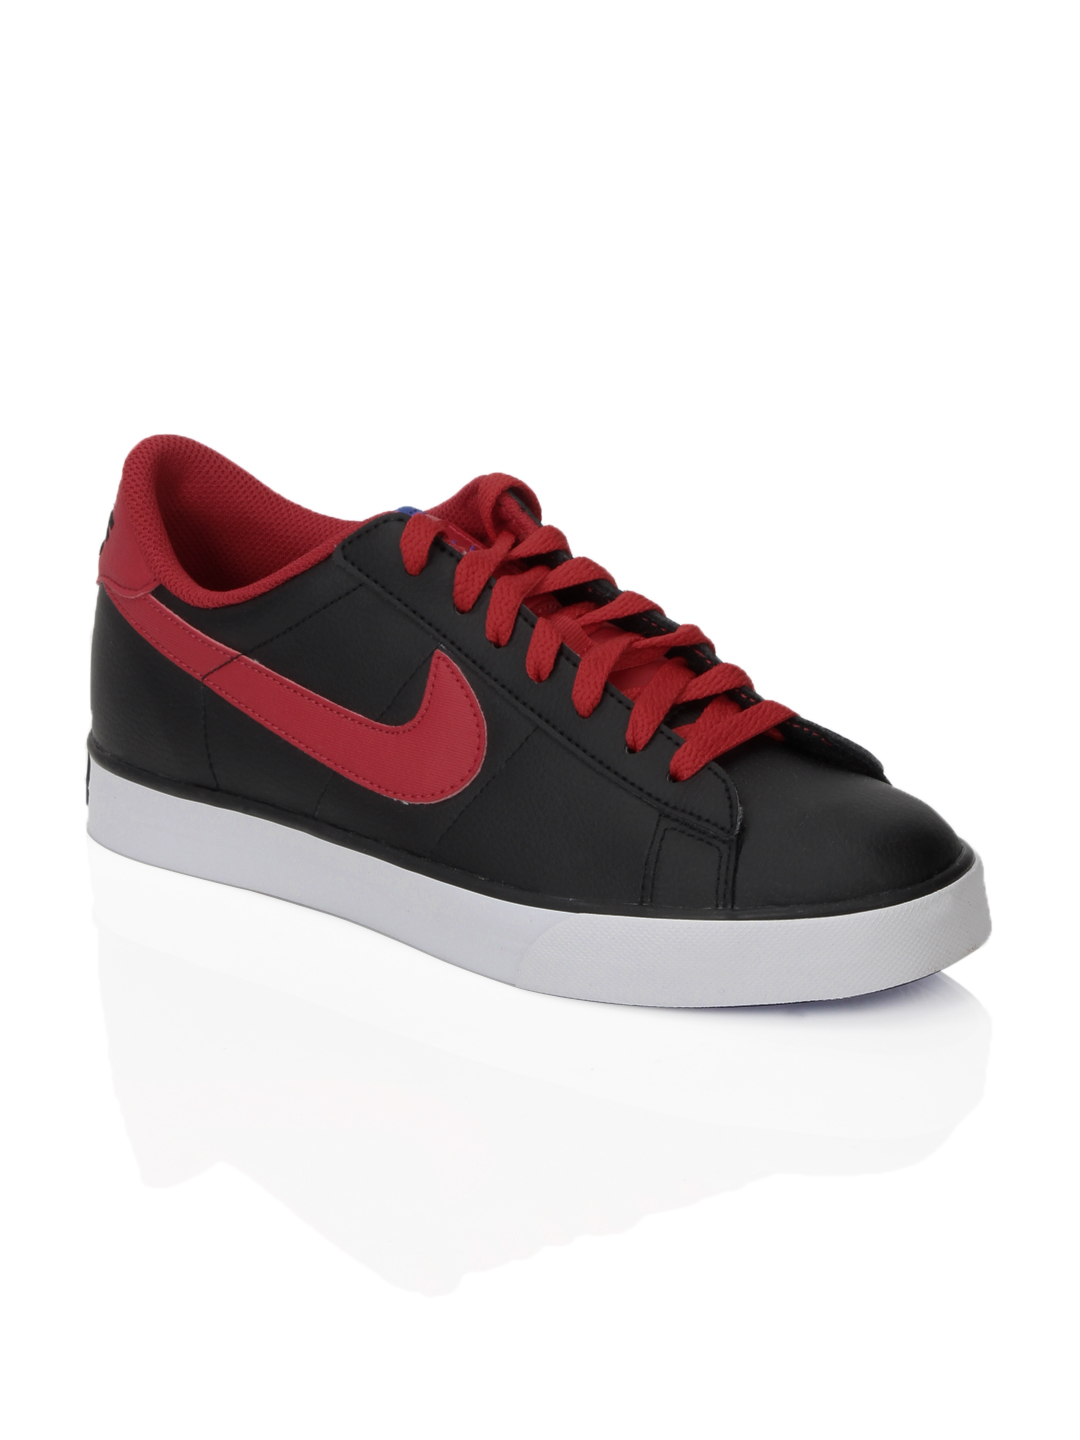

In [6]:
img_dir = r"fashion-dataset\fashion-dataset\images"
sample_img = Image.open(os.path.join(img_dir, str(ids[indices[0]]) + ".jpg"))
sample_img

In [ ]:
sim_img1 = Image.open(os.path.join(img_dir, str(ids[indices[1]]) + ".jpg"))
sim_img1

In [ ]:
sim_img2 = Image.open(os.path.join(img_dir, str(ids[indices[2]]) + ".jpg"))
sim_img2

In [ ]:
sim_img3 = Image.open(os.path.join(img_dir, str(ids[indices[3]]) + ".jpg"))
sim_img3

In [ ]:
sim_img4 = Image.open(os.path.join(img_dir, str(ids[indices[4]]) + ".jpg"))
sim_img4

In [6]:
img_dir = r"fashion-dataset\fashion-dataset\images"
test_img = Image.open(os.path.join(img_dir, "10000.jpg"))
model_ckpt = 'vit-base-fashion'
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)
model.eval()

c:\Users\sunny\Desktop\Home\Projects\Python\Visual Search\venv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at vit-base-fashion and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [8]:
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

def pp(batch):
    images = batch["image"]
    image_batch_transformed = torch.stack(
        [transformation_chain(image) for image in images]
    )
    new_batch = {"pixel_values": image_batch_transformed}
    with torch.no_grad():
        embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        del image_batch_transformed
    return {"embeddings": embeddings}


In [14]:
img_processed = transformation_chain(test_img)
img_processed = img_processed.unsqueeze(0)
# img_processed.shape
embeddings = model(img_processed).last_hidden_state[:, 0].cpu()